In [2]:
import io
import os
import pickle
import random as rn
import warnings
from importlib import reload
from multiprocessing import cpu_count

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from gensim.models import Word2Vec
from IPython.display import display
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, \
        MultilabelStratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, \
        average_precision_score, ndcg_score, \
        label_ranking_average_precision_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant, GlorotUniform
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, \
        GlobalMaxPooling1D, SpatialDropout1D, LSTM, GRU, Flatten, MaxPooling1D, \
        BatchNormalization, ReLU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import data
import models
import preprocessing

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)

## Extracting the data

In [3]:
# data.extract_data(extraction_dir="train",
#                   data_dir="data",
#                   data_zip_name="reuters-training-corpus.zip")

train_df = pd.read_pickle("train/data.pkl")

# train_df = data.get_docs_labels("train/REUTERS_CORPUS_2")
# train_df.to_pickle("train/data.pkl")

train_docs = train_df["doc"].values
train_labels = np.array(train_df["labels"].tolist())
n_labels = len(data.CODEMAP)

print(train_docs.shape)
print(train_labels.shape)
print(train_docs[2])
print(train_labels[2])

(299773,)
(299773, 126)
Toronto stocks end higher after volatile session. CHANGE				    CHANGE TSE	  5900.37    +50.15   HI 5900.37	    LO  5840.29 DJI	  6611.05    +27.57   GOLD (LONDON)   US$350.00 +1.90 FTSE100    4248.10    -64.80   GOLD (NY-COMEX) US$354.80 +0.70 NIKKEI    17869.59   -133.81   LME CASH NICKEL US$7659   +99.0 CANDLR	1.3883		 LME CASH ALUM   US$1602.0  -4.0 CAN 30-YR   107.41     -0.15   BRENT CRUDE     US$19.09  -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday, buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre-X Minerals hampered session * 84 million shares traded Toronto's key stock index ended higher on Tuesday as the saga of Bre-X Minerals Ltd and its Indonesian gold find continued to dominate Canada's biggest stock market. The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$1.4 billion. But the overall marke

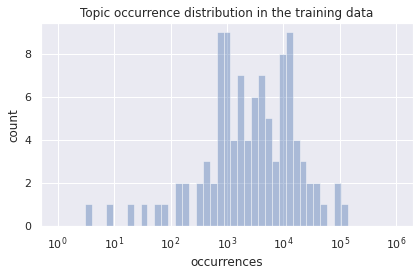

In [4]:
occurrences = pd.Series(np.sum(train_labels, axis=0), name="occurrences")
g = sns.distplot(occurrences, bins=np.logspace(0, 6), kde=False)
g.set_xscale("log")
g.set_ylabel("count")
g.set_title("Topic occurrence distribution in the training data")
plt.tight_layout()
plt.show()

In [5]:
print(sorted(np.sum(train_labels, axis=0)))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 8, 19, 38, 55, 70, 122, 141, 162, 187, 301, 348, 381, 401, 432, 591, 619, 664, 671, 704, 747, 760, 761, 778, 801, 857, 919, 949, 958, 975, 989, 989, 1019, 1043, 1101, 1310, 1358, 1423, 1479, 1560, 1658, 1675, 1843, 1890, 1892, 2011, 2111, 2153, 2280, 2429, 2708, 2770, 2971, 3177, 3245, 3393, 3682, 3794, 4089, 4222, 4251, 4254, 4693, 4996, 5383, 5693, 5759, 6244, 6565, 6731, 7419, 8350, 8429, 8641, 8658, 9757, 10253, 10668, 10930, 11210, 11298, 11338, 11705, 12592, 13040, 13216, 13862, 14398, 15598, 16055, 18675, 19124, 19593, 20042, 21499, 27095, 33786, 33963, 42374, 59207, 81940, 82580, 137531]


In [15]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=seed)

for train, test in msss.split(train_labels, train_labels):
    print(sorted(np.sum(train_labels[train], axis=0)))
    print(sorted(np.sum(train_labels[test], axis=0)))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 15, 30, 44, 56, 98, 113, 130, 150, 241, 278, 305, 321, 346, 473, 495, 531, 537, 563, 598, 608, 609, 622, 641, 686, 735, 759, 766, 780, 791, 791, 815, 834, 881, 1048, 1086, 1138, 1183, 1248, 1326, 1340, 1474, 1512, 1514, 1609, 1689, 1722, 1824, 1943, 2166, 2216, 2377, 2542, 2596, 2714, 2946, 3035, 3271, 3378, 3401, 3403, 3754, 3997, 4306, 4554, 4607, 4995, 5252, 5385, 5935, 6680, 6743, 6913, 6926, 7806, 8202, 8534, 8744, 8968, 9038, 9070, 9364, 10074, 10432, 10573, 11090, 11518, 12478, 12835, 14940, 15299, 15674, 16034, 17189, 21676, 27029, 27170, 33899, 47366, 65552, 66064, 110022]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 8, 11, 14, 24, 28, 32, 37, 60, 70, 76, 80, 86, 118, 124, 133, 134, 141, 149, 152, 152, 156, 160, 171, 184, 190, 192, 195, 198, 198, 204, 209, 220, 262, 272, 285, 296, 312, 332, 335, 369, 378, 378, 402, 422, 431, 456, 486, 542, 554, 594, 635, 649, 679, 736,

In [19]:
mskf = MultilabelStratifiedKFold(n_splits=5, random_state=seed)

for train, test in mskf.split(train_labels, train_labels):
    print(sorted(np.sum(train_labels[train], axis=0)))
    print(sorted(np.sum(train_labels[test], axis=0)))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 15, 31, 44, 56, 97, 112, 129, 150, 241, 278, 304, 320, 346, 473, 495, 532, 537, 564, 598, 608, 609, 622, 641, 686, 736, 760, 767, 780, 792, 792, 816, 835, 881, 1048, 1086, 1138, 1183, 1248, 1326, 1340, 1475, 1512, 1514, 1609, 1689, 1722, 1824, 1943, 2166, 2216, 2377, 2542, 2596, 2714, 2946, 3035, 3271, 3378, 3401, 3403, 3755, 3997, 4307, 4555, 4607, 4995, 5252, 5385, 5935, 6680, 6743, 6913, 6926, 7806, 8202, 8535, 8744, 8968, 9039, 9070, 9364, 10074, 10432, 10573, 11090, 11519, 12479, 12848, 14940, 15300, 15675, 16034, 17199, 21676, 27029, 27171, 33908, 47366, 65552, 66064, 110032]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 7, 11, 14, 25, 29, 33, 37, 60, 70, 77, 81, 86, 118, 124, 132, 134, 140, 149, 152, 152, 156, 160, 171, 183, 189, 191, 195, 197, 197, 203, 208, 220, 262, 272, 285, 296, 312, 332, 335, 368, 378, 378, 402, 422, 431, 456, 486, 542, 554, 594, 635, 649, 679, 736,